In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from saturation.utils import *

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Configuration

In [10]:
BASE_PATH = "/data/saturation/thesis_run_20250223/"

# Simulation IDs for the training set
MIN_SIMULATION_ID = 1
MAX_SIMULATION_ID = 150
simulation_ids = list(range(MIN_SIMULATION_ID, MAX_SIMULATION_ID + 1))

N_NSTATS = 1

FONT_SIZE = 24
DPI = 400

# Estimates of slope for each simulation

In [11]:
configs_df = read_configs_pandas(base_path=BASE_PATH)
configs_dict = configs_df.set_index("simulation_id").to_dict(orient="index")

In [12]:
states_sub_dfs = []
for simulation_id in simulation_ids:
    state = pd.read_parquet(f"data/states_{simulation_id}_{N_NSTATS}.parquet")
    states_sub_dfs.append(state)
states = pd.concat(states_sub_dfs, axis=0)
del states_sub_dfs

In [13]:
slope_estimates = []
for simulation_id in simulation_ids:
    state = states.loc[simulation_id].copy()
    mle_slope, sigma = estimate_cumulative_slope(
        radii=state.radius,
        rmin=configs_dict[simulation_id]["rstat"],
        rmax=configs_dict[simulation_id]["rmax"],
        min_search_slope=-10.0,
        max_search_slope=-1
    )

    result = {
        "simulation_id": simulation_id,
        "b_p": configs_dict[simulation_id]["slope"],
        "exponent": configs_dict[simulation_id]["rim_erasure_method"]["exponent"],
        "mle_slope": mle_slope,
        "mle_slope_sigma": sigma
    }
    slope_estimates.append(result)
    
df = pd.DataFrame.from_dict(slope_estimates, orient="columns")

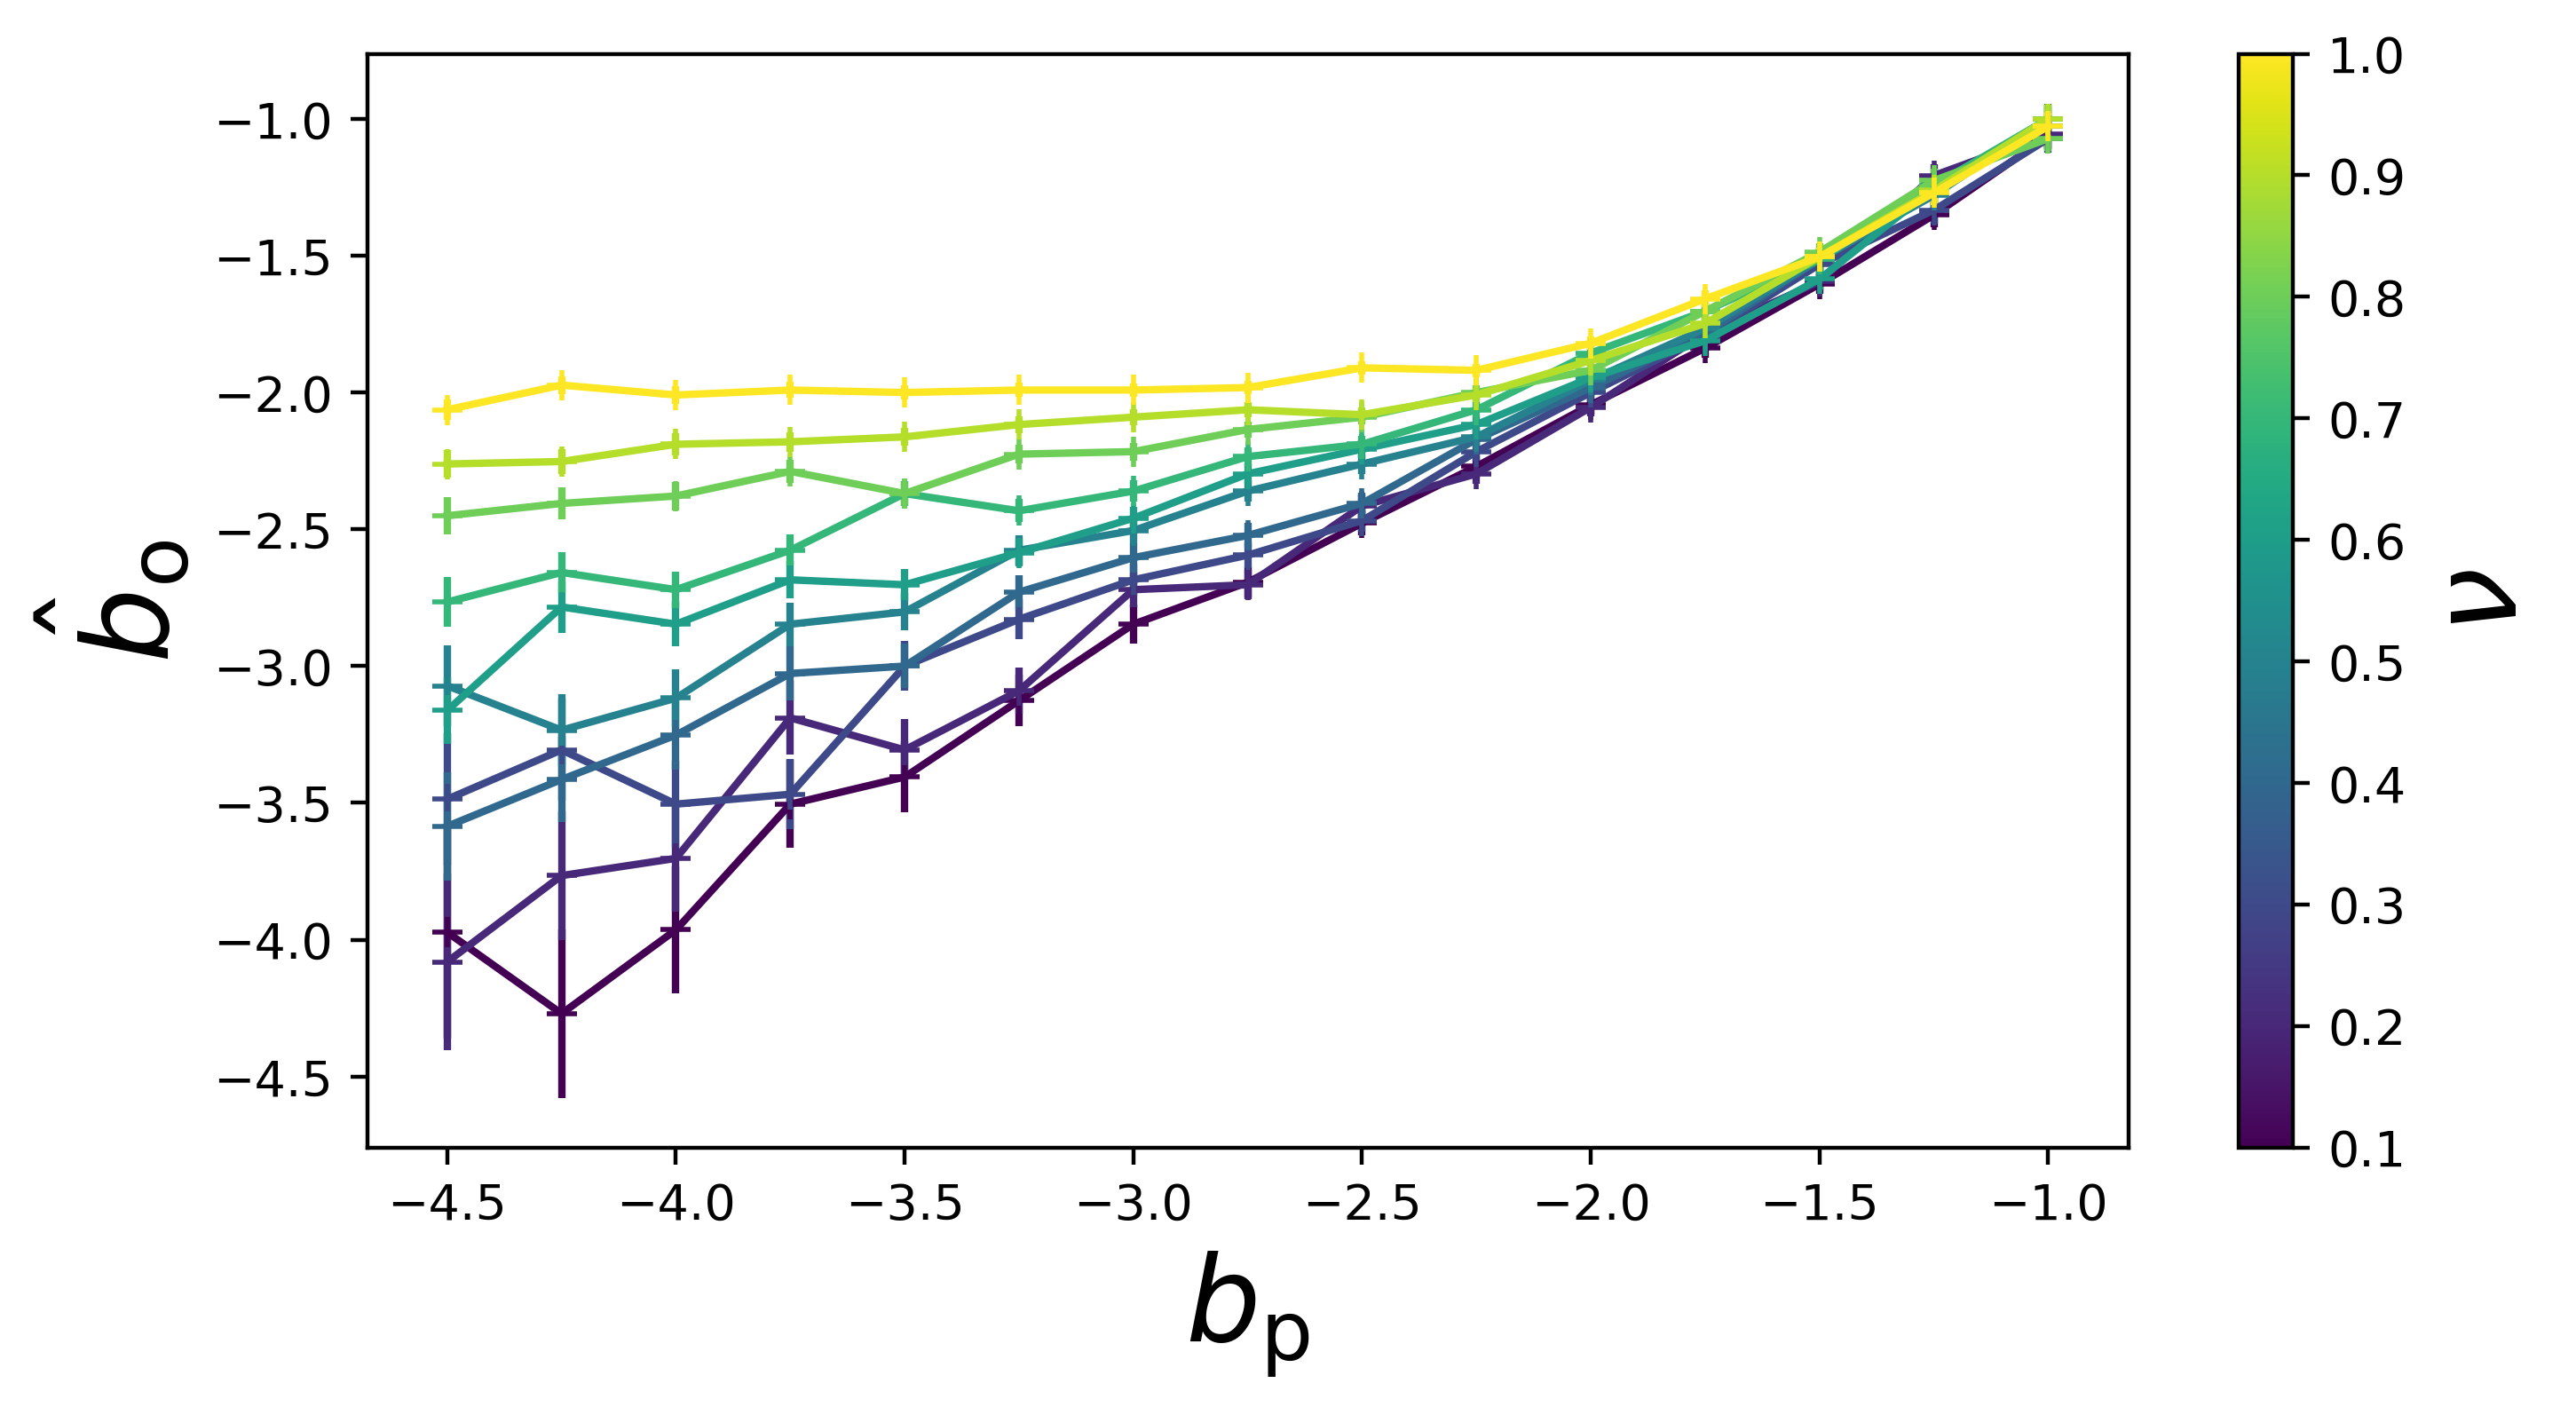

In [14]:
fig = plt.figure(figsize=(8, 4), dpi=DPI)
ax = fig.add_subplot(111)

# Normalize color variable to range [0, 1] for the colormap
norm = plt.Normalize(df["exponent"].min(), df["exponent"].max())

for exponent in df.exponent.drop_duplicates().sort_values():
    d = df[df.exponent == exponent].sort_values("b_p").copy()
    ax.errorbar(
        d.b_p,
        d.mle_slope,
        d.mle_slope_sigma,
        marker="+",
        # ls="",
        color=cm.viridis(norm(exponent)),
        ecolor=cm.viridis(norm(exponent))
    )

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\nu$", fontsize=FONT_SIZE)

ax.set_xlabel(r"$b_{\text{p}}$", fontsize=FONT_SIZE)
ax.set_ylabel(r"$\hat{b}_{\text{o}}$", fontsize=FONT_SIZE)

plt.savefig(f"figures/mle_estimated_slopes_{N_NSTATS}_nstat.png", bbox_inches="tight")

plt.show()